# Anomaly Detection Practice

In this note, we will study an anomaly detection problem. Due to existence of labels on the data, I will classify this as a supervised learning problem. 

There are almost 2 million rows and 17 features, and the number of fraud transactions is only about 8000. Therefore the data is highly skewed. In the note, we will first check through the categorical features. I didn't find any significant difference to identify frauds and normal transactions. For each categorical feature, we perform a chi-square test to find the p-value; the null hypothesis $-$ negative (normal) data has same categorical distribution as positive (fraud) one. We found all hypothesis testing shows large p-value, so we cannot reject the null hypothesis, i.e. the categorical distributions of negative and positive sample is the same (or similar). But one interesting indication is that fraud transactions used to repeat 'device_id' and 'fuzzy_device_id'.

Next we move to continuous features. In addition to 'page_time_on' and 'transaction_amount', we found 'time_diff' defined as time difference between 'device_first_seen' and the transaction time 'datetime' could be useful. They significantly show different distribution behavior, like different median/mean values, for frauds and normal transactions. In particular, even using modified Z score of 'transaction_amount' as classifier can reach 60% recall. 

Based on the above analysis, I simply consider the three continuous features and build machine learning models. We tried logistic regression, random forest and finally ensemble learning. I firstly separate training/test dataset and only use training dataset for modelling. For each model, I undersample the majority (normal data), and then combine all fraud data and subset of the normal transaction to generate new dataset for training. The model performance is given by using test dataset.

While the new dataset has less fraud-normal ratio = 1:5, the model gives higher recall but low precision. Whereas including more normal data, say fraud-normal ratio = 1:50, the recall drops but precision enhances. Thus there exists trade-off between precision and recall. To determine the right metric, it depends on how much cost for getting a  false negative and missing a false negative. To compromise, I select Macro F1 score as the metric to select the optimal classification model. Meanwhile, I also visualize both precision-recall and ROC curves, and compute the area under the curves (AUC) for performance comparison. Higher AUC values denote a better model. From the models I adventured here, **random forest and ensemble learning show similar performance and both outperform logistic regression**. The **most important feature is 'transaction_amount'**.

The content of the note is as follows. The Sec. 1 and Sec. 2 are the analysis of features by comparing frauds and normal data. Sec. 3 is devoted to modeling. 

    0. Data Preparation
    1. Categorical Feature
      1.1 'browser_language'
      1.2 'os' and 'ua_os'
      1.3 'os_anomaly' and 'browser_language_anomaly'
      1.4 'true_ip_geo'
      1.5 'proxy_ip_geo'
      1.6 'device_id' and 'fuzzy_device_id'
    2. Continuous Feature
      2.1 'time_diff'
      2.2 'page_time_on'
      2.3 'transaction_amount'
    3. Machine Learning
      3.1 Data manipulation and Pipeline
      3.2 Logistic Regression
      3.3 Random Forest
      3.4 Ensemble Learning

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
from scipy.stats import chisquare

# 0. Data Preparation

In [2]:
data = pd.read_csv('/Users/hhung/Desktop/tmx_data.csv')

In [3]:
data.shape

(1931530, 17)

In [4]:
data.head()

,datetime,browser_language,device_id,device_first_seen,os,os_anomaly,ua_os,browser_language_anomaly,fuzzy_device_id,fuzzy_device_first_seen,true_ip,true_ip_geo,proxy_ip,proxy_ip_geo,page_time_on,transaction_amount,frd
0,2017-02-03 15:27:56.434,en-GB,b997731646e641c2a67be8b78977cec4,2016-07-20 00:00:00.000,Windows,NaN,win10,NaN,b997731646e641c2a67be8b78977cec4,2016-07-20 00:00:00.000,86.3.57.193,GB,NaN,NaN,12474.0,985.0,1
1,2017-02-06 12:12:37.806,"en-US,en;q=0.8",f898b94549f148cd9e7553d4cb0b1b18,2017-02-06 00:00:00.000,Windows,NaN,win7,NaN,f898b94549f148cd9e7553d4cb0b1b18,2017-02-06 00:00:00.000,82.5.29.233,GB,NaN,NaN,42533.0,995.0,1
2,2017-02-06 11:10:12.312,en-GB,ffd09ef2f216457aac5d295a74df6976,2017-01-31 00:00:00.000,Windows,NaN,win10,NaN,ffd09ef2f216457aac5d295a74df6976,2017-01-31 00:00:00.000,86.141.251.95,GB,NaN,NaN,3020.0,1732.9,1
3,2017-02-07 14:35:25.556,"en-GB,en;q=0.5",9f72df7fefee430a87558817f2a6b29a,2016-12-13 00:00:00.000,Windows,NaN,win7,NaN,9f72df7fefee430a87558817f2a6b29a,2016-12-13 00:00:00.000,79.78.127.191,GB,NaN,NaN,13179.0,3110.0,1
4,2017-02-08 14:24:39.853,"en-GB,en-US;q=0.8,en;q=0.6",9dd8b168a5f1486db191c57efeaf2935,2017-02-08 00:00:00.000,Windows,NaN,NaN,NaN,9dd8b168a5f1486db191c57efeaf2935,2017-02-08 00:00:00.000,94.197.0.167,GB,NaN,NaN,6339.0,6.5,1


In [5]:
time_diff = []
for i, row in enumerate(data.iterrows()):
    row = row[1]
    if pd.isnull(row['datetime']) == False and pd.isnull(row['device_first_seen']) == False:
        time_2 = row['datetime'].split(' ')[0]
        time_1 = row['device_first_seen'].split(' ')[0]
        time_diff.append((datetime.strptime(time_2, '%Y-%m-%d')-datetime.strptime(time_1, '%Y-%m-%d')).days)
    else:
        time_diff.append(float('nan'))

data['time_diff'] = time_diff

In [6]:
pos_data, neg_data = data[data.frd == 1], data[data.frd == 0]
len(pos_data), len(neg_data)

(7986, 1923544)

# 1. Categorical Feature

Here we will walk through the categorical features. For each, we perform chi-square testing to compare normal data pool and fraud data pool. The null hypothesis is 

$$H_0: \textrm{categorical variable distribution for positive sample} = \textrm{categorical variable distribution for negative sample}$$

and the alternative hypothesis is they are not equal. We found all have large p-value, i.e. these distributions are the same. Thus I won't use the catgeorical features for later modeling.

In [6]:
def category_dict(feature, x):
    '''given a feature list x, return the categorical count dictionary
       e.g. x = [A, A, B, A, C, C]
       return {A: 3, B:1, C: 2}
    '''
    x_dict = {}
    for i in x:
        x_dict[i] = x_dict.get(i, 0) + 1
        
    x_dict = {i: round(x_dict[i]*1.0/len(x), 4) for i in x_dict}
    sorted_x = sorted(x_dict.items(), key=lambda kv: kv[1], reverse=True)
    category, ratio = [], []
    for item in sorted_x:
        category.append(item[0])
        ratio.append(item[1])
    return x_dict, pd.DataFrame({feature: category, 'ratio': ratio})

## 1.1 'browser_language'

In [215]:
neg = neg_data['browser_language'].tolist()
pos = pos_data['browser_language'].tolist()
print (len(set(neg)), len(set(pos)))

4939 59


In [216]:
neg_category_dict, neg_table = category_dict('browser language', neg)
pos_category_dict, pos_table = category_dict('browser language', pos)

In [199]:
pd.DataFrame(neg_table).head()

,browser language,ratio
0,"en-US,en;q=0.8",0.2057
1,en-GB,0.1787
2,"en-GB,en-US;q=0.8,en;q=0.6",0.1585
3,en-gb,0.1547
4,"en-GB,en;q=0.5",0.0826


In [200]:
pd.DataFrame(pos_table).head()

,browser language,ratio
0,"en-US,en;q=0.8",0.2514
1,"en-GB,en-US;q=0.8,en;q=0.6",0.1804
2,en-gb,0.1634
3,en-GB,0.1146
4,"en-GB,en;q=0.5",0.0849


In [217]:
chisquare(pos_table['ratio'][:10], f_exp=[neg_category_dict[x] for x in pos_table['browser language'][:10]])

Power_divergenceResult(statistic=0.15583592016610731, pvalue=0.99999981555967066)

## 1.2 'os' and 'ua_os'

In [221]:
neg = neg_data['os'].tolist()
pos = pos_data['os'].tolist()
print (len(set(neg)), len(set(pos)))

neg_category_dict, neg_table = category_dict('os', neg)
pos_category_dict, pos_table = category_dict('os', pos)

10 10


In [222]:
chisquare(pos_table['ratio'][:10], f_exp=[neg_category_dict[x] for x in pos_table['os'][:10]])

Power_divergenceResult(statistic=0.13718594693649608, pvalue=0.9999998952746616)

In [223]:
neg = neg_data['ua_os'].tolist()
pos = pos_data['ua_os'].tolist()
print (len(set(neg)), len(set(pos)))
neg_category_dict, neg_table = category_dict('ua_os', neg)
pos_category_dict, pos_table = category_dict('ua_os', pos)

185 38


In [224]:
chisquare(pos_table['ratio'][:10], f_exp=[neg_category_dict[x] for x in pos_table['ua_os'][:10]])

Power_divergenceResult(statistic=0.16019778188824921, pvalue=0.9999997915351494)

In [228]:
neg_table.head()

,ratio,ua_os
0,0.3028,win10
1,0.2117,win7
2,0.1321,macosx
3,0.1226,ios
4,0.0597,NaN


In [229]:
pos_table.head()

,ratio,ua_os
0,0.3278,win10
1,0.1793,ios
2,0.1784,win7
3,0.0940,NaN
4,0.0721,win8.1


## 1.3 'os_anomaly' and 'browser_language_anomaly'

In [10]:
neg = neg_data['os_anomaly'].tolist()
pos = pos_data['os_anomaly'].tolist()
print (len(set(neg)), len(set(pos)))
neg_category_dict, neg_table = category_dict('os_anomaly', neg)
pos_category_dict, pos_table = category_dict('os_anomaly', pos)

(2, 2)


In [11]:
neg_table.head()

,os_anomaly,ratio
0,NaN,0.9542
1,True,0.0458


In [232]:
pos_table.head()

,os_anomaly,ratio
0,NaN,0.9335
1,True,0.0665


In [233]:
neg = neg_data['browser_language_anomaly'].tolist()
pos = pos_data['browser_language_anomaly'].tolist()
neg_category_dict, neg_table = category_dict('os_anomaly', neg)
pos_category_dict, pos_table = category_dict('os_anomaly', pos)

In [234]:
neg_table.head()

,os_anomaly,ratio
0,NaN,0.9994
1,True,0.0006


In [235]:
pos_table.head()

,os_anomaly,ratio
0,NaN,0.9997
1,True,0.0003


## 1.4 'true_ip_geo'

In [12]:
neg = neg_data['true_ip_geo'].tolist()
pos = pos_data['true_ip_geo'].tolist()
print (len(set(neg)),  len(set(pos)))
neg_category_dict, neg_table = category_dict('true_ip_geo', neg)
pos_category_dict, pos_table = category_dict('true_ip_geo', pos)

(205, 24)


In [243]:
neg_table.head()

,ratio,true_ip_geo
0,0.9266,GB
1,0.0201,NaN
2,0.0144,IE
3,0.0039,US
4,0.0035,ES


In [244]:
pos_table.head()

,ratio,true_ip_geo
0,0.9242,GB
1,0.0491,NaN
2,0.0095,IN
3,0.0038,NG
4,0.0024,IE


In [18]:
f_exp = []
pos_sample = []
for x in pos_table['true_ip_geo'][:10]:
    if x in neg_category_dict:
        pos_sample.append(pos_category_dict[x])
        f_exp.append(neg_category_dict[x])

chisquare(pos_sample, f_exp=f_exp)

Power_divergenceResult(statistic=0.071322732895690452, pvalue=0.99999928383760428)

## 1.5 'proxy_ip_geo'

In [245]:
neg = neg_data['proxy_ip_geo'].tolist()
pos = pos_data['proxy_ip_geo'].tolist()
print (len(set(neg)),  len(set(pos)))
neg_category_dict, neg_table = category_dict('proxy_ip_geo', neg)
pos_category_dict, pos_table = category_dict('proxy_ip_geo', pos)

103 11


In [248]:
neg_table.head()

,proxy_ip_geo,ratio
0,NaN,0.9905
1,GB,0.0082
2,US,0.0003
3,NL,0.0002
4,FR,0.0001


In [249]:
pos_table.head()

,proxy_ip_geo,ratio
0,NaN,0.9703
1,GB,0.0257
2,NL,0.0014
3,DE,0.0008
4,US,0.0006


In [247]:
chisquare(pos_table['ratio'][:5], f_exp=[neg_category_dict[x] for x in pos_table['proxy_ip_geo'][:5]])

Power_divergenceResult(statistic=0.050159514534418442, pvalue=0.99969071210334293)

## 1.6 'device_id' and 'fuzzy_device_id'

For these two features, though there are a lot of various 'device_id' and 'fuzzy_device_id' for transactions, I found **'device_id' and 'fuzzy_device_id' for frauds repeat to appear more frequently**. As shown below, expcet 'Nan', there are no dominating 'device_id' appeared for normal tranactions, but for frauds, many 'device_id' repeat to appear. Thus in future, we can identify if the 'device_id' has extraordinarily high frequency to appear, it is possible to be an outlier.

In [310]:
len(set(data['device_id'].tolist())), len(set(data['fuzzy_device_id'].tolist()))

(1152277, 1094182)

In [252]:
category_dict('device_id', neg_data['device_id'].tolist())[1].head(8)

,device_id,ratio
0,NaN,0.0174
1,2c3e11adf10140018815200b305bd897,0.0001
2,11f71c4309704ac69e5df1212d0f0b99,0.0001
3,0f0116e81d184e7ab7ee8ba494583b43,0.0001
4,e964c8c578ad454cbe82bd7d04926b83,0.0001
5,ec49f88893ff4d469825118f71059705,0.0001
6,40180a0325424845a42c646073768ac9,0.0001
7,d7ca99cdeeb148acafcfba1337e1ac51,0.0001


In [257]:
category_dict('device_id', pos_data['device_id'].tolist())[1].head(10)

,device_id,ratio
0,NaN,0.0293
1,c6e5bcdd43344a0c9bb04fd7e8361a96,0.0116
2,cb5f4ac919c749ffb63a333050ce1017,0.0115
3,3d72ff8e771b4cd7930365f86527be85,0.0095
4,d705de64f5ac46efaf9f85ee4fbdc878,0.0095
5,85848fe04e114f93ae83ce4a4daeb834,0.0085
6,c7aa168af34e4a0e99da24da0d9b4805,0.0073
7,84eed3c683b94dd791a9866fe572e6b0,0.0070
8,f4e9eedc37c14cd38725e8480be6618d,0.0070
9,9ce5f2e263c6405b960c7014fcb37062,0.0056


In [254]:
category_dict('fuzzy_device_id', neg_data['fuzzy_device_id'].tolist())[1].head(8)

,fuzzy_device_id,ratio
0,NaN,0.0159
1,44c78bb2ef7e40babe2ec65e4a3a3166,0.0002
2,11f71c4309704ac69e5df1212d0f0b99,0.0001
3,0ffda682aeb54a2b9dee361cd24fc5dc,0.0001
4,3560c753dbd84c9ab1d8d6eb3cbfc814,0.0001
5,0f0116e81d184e7ab7ee8ba494583b43,0.0001
6,5dd13737365e454e9ea9094355fe1e6a,0.0001
7,ec49f88893ff4d469825118f71059705,0.0001


In [256]:
category_dict('fuzzy_device_id', pos_data['fuzzy_device_id'].tolist())[1].head(10)

,fuzzy_device_id,ratio
0,NaN,0.0284
1,c6e5bcdd43344a0c9bb04fd7e8361a96,0.0116
2,cb5f4ac919c749ffb63a333050ce1017,0.0115
3,b4acc77ccab0409a99801ca0411a7984,0.0100
4,3d72ff8e771b4cd7930365f86527be85,0.0095
5,85848fe04e114f93ae83ce4a4daeb834,0.0085
6,aada26dfeca347e998998cf59bda2d57,0.0073
7,84eed3c683b94dd791a9866fe572e6b0,0.0070
8,f4e9eedc37c14cd38725e8480be6618d,0.0070
9,9ce5f2e263c6405b960c7014fcb37062,0.0056


# 2. Continuous Feature

Here we will analyze different continuous features for normal data and fraud. In addition to 'page_time_on' and 'transaction_amount', I found 'time_diff' defined as time difference between 'datetime' and 'device_first_seen' also indicates some a useful signal to distinguish frauds and normal data.

There exist two easy ways to statistically inference outlier $-$ [Z score and modified Z score](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm). The modified Z score is defined as

$$M_i = \frac{0.6745(x_i-\tilde{x})}{\textrm{MAD}},$$

where $\tilde{x}$ denotes the median of $\lbrace x_1, x_2, \cdots\rbrace$ and MAD denoting the median absolute deviation.  As modified Z-scores with an absolute value is greater than 3.5, it is labeled as potential outliers.

For each, I will compare distribution of positive and negative samples using hisgram and boxplot. I found all of them do not show a normal distribution, and not even an approximate normal distribution. Therefore, I won't calculate Z score. However, the modified Z score carries some useful information to identify outliers.

In [261]:
def get_MAD(x_list):
    '''to calculate median absolute deviation
    '''
    x_list = [x for x in x_list if not np.isnan(x)]
    median = np.median(x_list)
    return median, np.median([abs(x-median) for x in x_list])

def modified_Z_classifier(pos_data, median, MAD):
    '''to calculate recall if using modified Z score as classifier'''
    ct, fraud_ct = 0, 0
    nan_ct = 0
    for x in pos_data.tolist():
        if not np.isnan(x):
            ct += 1 
            if abs(0.6745*(x-median)/MAD) > 3.5:
                fraud_ct += 1
        else:
            nan_ct += 1
        
    print ('recall =', round(fraud_ct*1.0/ct, 3))
    print ('nan ratio =', round(nan_ct*1.0/ct, 3))

## 2.1 'time_diff'

The feature 'time_diff' shows signficiant difference between fraud and normal samples. For fraud transactions, the time between 'datetime' and 'device_first_seen' are much shorter compared to normal ones; **fraud: median = 1 day and mean = 60 days, normal: median = 71 days and mean = 159 days**. The fraud data has stronger skewed distribution than the normal one. However, the simple modified Z score classifier still shows low recall, but the feature will be useful for later machine learning model.

In [306]:
neg = [x for x in neg_data['time_diff'].tolist() if not np.isnan(x)]
pos = [x for x in pos_data['time_diff'].tolist() if not np.isnan(x)]

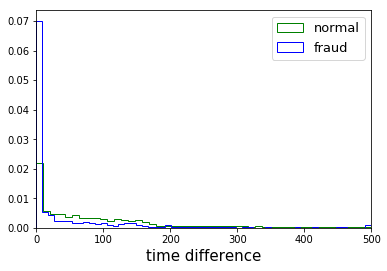

In [307]:
plt.hist(neg, 200, normed=1, color='green', histtype='step', label ='normal')
plt.hist(pos, 200, normed=1, color='blue', histtype='step', label='fraud')
plt.legend(loc='best', fontsize=13)
plt.xlabel('time difference', fontsize=15)
plt.xlim(0, 500)
plt.show()

In [259]:
np.median(neg), np.median(pos)

(71.0, 1.0)

In [287]:
np.mean(neg), np.mean(pos)

(159.4222698276935, 59.768068758952985)

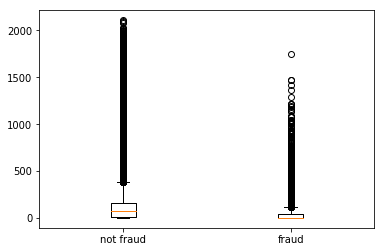

In [285]:
plt.boxplot([neg, pos], labels=['not fraud', 'fraud'])
plt.show()

In [261]:
neg_median, MAD = get_MAD(neg_data['time_diff'].tolist())

In [284]:
modified_Z_classifier(pos_data['time_diff'], neg_median, MAD)

recall = 0.044
nan ratio = 0.04


## 2.2 'page_time_on'

On the other hand, 'page_time_on' feature shows a less signficiant signal to identify fraud and normal samples from the histgram. **Fraud: median = 11174 and mean = 35697, normal: median = 9783 and mean = 18756**. However, the simple modified Z score classifier shows a higher recall than using 'time_diff'. We will also implement the continuous feature for later machine learning model.

In [308]:
neg = [x for x in neg_data['page_time_on'].tolist() if not np.isnan(x)]
pos = [x for x in pos_data['page_time_on'].tolist() if not np.isnan(x)]

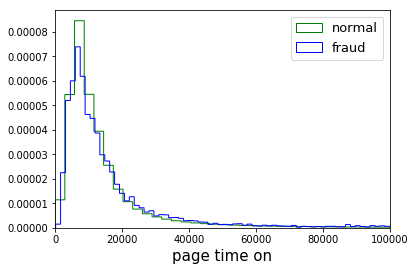

In [309]:
plt.hist(neg, 2000, normed=1, color='green', histtype='step', label ='normal')
plt.hist(pos, 2000, normed=1, color='blue', histtype='step', label='fraud')
plt.legend(loc='best', fontsize=13)
plt.xlabel('page time on', fontsize=15)
plt.xlim(0, 100000)
plt.show()

In [289]:
np.median(neg), np.median(pos)

(9783.0, 11174.0)

In [290]:
np.mean(neg), np.mean(pos)

(18756.039420922218, 35697.099445375985)

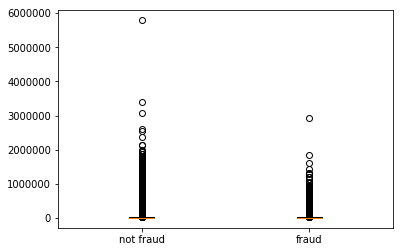

In [295]:
plt.boxplot([neg, pos], labels=['not fraud', 'fraud'])
plt.show()

In [296]:
neg_median, MAD = get_MAD(neg_data['page_time_on'].tolist())
modified_Z_classifier(pos_data['page_time_on'], neg_median, MAD)

recall = 0.161
nan ratio = 0.03


## 2.3 'transaction_amount'

Finally, 'transaction_amount' strongly shows signficiant difference between fraud and normal samples. Fraud transactions have larger median and mean values compared to normal ones. **Fraud: median = 1800 and mean = 3076, normal: median = 200 and mean = 464**. The fraud data distribution has a long tail whereas normal transactions are more right-skewed. Moreover, the simple modified Z score classifier shows a surprisingly high recall performance: about 0.6. Thus 'transaction_amount' will be also implemented in later machine learning models.

In [262]:
neg = [x for x in neg_data['transaction_amount'].tolist() if not np.isnan(x)]
pos = [x for x in pos_data['transaction_amount'].tolist() if not np.isnan(x)]

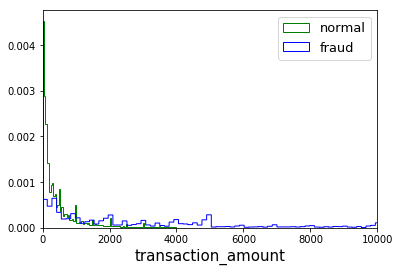

In [305]:
plt.hist(neg, 100, normed=1, color='green', histtype='step', label ='normal')
plt.hist(pos, 5000, normed=1, color='blue', histtype='step', label='fraud')
plt.legend(loc='best', fontsize=13)
plt.xlabel('transaction_amount', fontsize=15)
plt.xlim(0, 10000)
plt.show()

In [299]:
np.median(neg), np.median(pos)

(200.0, 1800.0)

In [298]:
np.mean(neg), np.mean(pos)

(464.65321993430535, 3076.8936477665429)

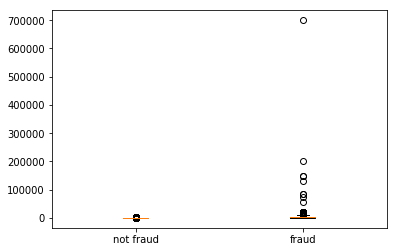

In [169]:
#neg_sample = np.array(neg_data['transaction_amount'].tolist())[np.random.randint(len(neg_data), size=100000)]
plt.boxplot([neg, pos], labels=['not fraud', 'fraud'])
plt.show()

In [263]:
neg_median, MAD = get_MAD(neg_data['transaction_amount'].tolist())
modified_Z_classifier(pos_data['transaction_amount'], neg_median, MAD)

('recall =', 0.59)
('nan ratio =', 0.022)


# 3. Machine Learning 

Next I will perform machine learning models $-$ logistic regression, random forest and ensemble learning to classify the fraud transactions against normal data. The data is imblanced. At beginning I split the training/test dataset. I only use the test dataset for performance comparison, and the remaining dataset to training ML models.
To implement the classification models, I tried to undersample the majority (normal transactions), and then combine all frauds and subset of normal transaction to generate new dataset for model training. 

I simply consider several fraud-normal ratio combinations $-$ 1:5, 1:12 and 1:50 etc. While the new dataset has less undersampling majority (1:5), the model gives higher recall but low precision. Whereas including more normal data (like 1:50), the recall drops but precision enhances.
Random forest gives outperforms logistic regression and slighlty ensemble learning. 


For such an imbalanced problem, accuracy is not a right metric. For anomaly detection, usually we need high recall (sucessfully predict more frauds). However, once recall is too high, we have very low precision, meaning too many False positives $-$ we predict the transaction is a fraud but it is actually not. This may result in losing customers' trust and confidence. The trade-off between precision and recall depends on how much cost for getting a false negative and missing a false negative.

To compromise, I select **Macro F1** score as the metric to select the optimal classification model. But eventually I also plot **precision-recall curves** rather than ROC curve and compute the AUC under the curves for performance comparison. Higher AUC values denote a better model is.

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn import grid_search
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.lines as mlines
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

## 3.1 Data manipulation and Pipeline

In the following I will show the procedures for the data pipeline. Note I first extract test dataset and only use the training dataset for model training.

    (a) Implement feature subset of fraud and normal data
    (b) Split the entire data to training/test dataset
    (c) Undersample normal data and concatenate fraud data to generate new dataset
    (d) Shuffle undersampled dataset and split training/test dataset
    (e) Training model

### a. Implement feature subset of fraud and normal data

In [9]:
sub_neg_data = neg_data[['time_diff', 'page_time_on', 'transaction_amount', 'frd']].dropna()
sub_pos_data = pos_data[['time_diff', 'page_time_on', 'transaction_amount', 'frd']].dropna()

In [10]:
neg_data.shape, sub_neg_data.shape

((1923544, 18), (1888202, 4))

In [11]:
pos_data.shape, sub_pos_data.shape

((7986, 18), (7679, 4))

### b. Split the entire data to training/test dataset

Here I separate the 'X_test' and 'y_test' as test datasets for performance comparison. While training models, I won't use the dataset.

In [12]:
train_neg, test_neg = train_test_split(sub_neg_data, test_size=0.3)
train_pos, test_pos = train_test_split(sub_pos_data, test_size=0.3)

In [18]:
test_data = pd.concat([test_neg, test_pos]).sample(frac=1)

In [19]:
X_test = test_data[['time_diff', 'page_time_on', 'transaction_amount']]
y_test = test_data['frd']

In [20]:
X_test.shape

(568765, 3)

### c. Undersample normal data and concatenate fraud data to generate new dataset

Below test_size are 0.02, 0.05 and 0.2, denoting 2%, 5% and 20% subset of normal transactions. Here is to undersample the normal dataset.

In [186]:
training_data = train_test_split(train_neg, test_size=0.2)
training_data = pd.concat([X[1], train_pos])

In [100]:
X[1].shape

(660871, 4)

In [101]:
training_data.shape

(666246, 4)

### d. Shuffle undersampled dataset  and split training/test dataset

In [193]:
training_data = training_data.sample(frac=1)
X_train = training_data[['time_diff', 'page_time_on', 'transaction_amount']]
y_train = training_data['frd']

### e. Training model

Here we just simply try a logistic regression model without regularization:

In [195]:
best_logreg_model = LogisticRegression()
best_logreg_model.fit(X_train, y_train)
pred = best_logreg_model.predict(X_test)
print ('accuracy = %.3f' %best_logreg_model.score(X_test, y_test))
conf_matrix = confusion_matrix(y_test, pred, labels=[1, 0])
TP, FP, FN, TN = conf_matrix[0][0], conf_matrix[1][0], conf_matrix[0][1], conf_matrix[1][1]
precision, recall = TP*1.0/sum(pred), TP*1.0/sum(y_test)
print ('P = %.3f' %precision, 'R = %.3f' %recall)
print ('F1 = %.3f ' %(2*precision*recall/(precision+recall)))
print (conf_matrix)

accuracy = 0.991
('P = 0.166', 'R = 0.322')
F1 = 0.219 
[[   741   1563]
 [  3713 562748]]


## 3.2 Logistic Regression

Now we can run through all data pipeline and ML for once. We try seversal fraud-normal data ratio majority strategies $-$ 1:5, 1:12, 1:50, 1:125, 1:200. First we use the logisit regression model. The followings are the functions for training ML models and evaluating the metrics.

### a. Codes for combined procedures

In [15]:
def logisitic_regression(X_train, y_train):
    '''training a logistic regression model with L2 regularization'''
    best_logreg_model = None
    max_score = -1
    best_reg = -1
    for regularization_param in [0.2, 0.4, 0.6, 0.8, 1, 1.2]:
        logreg = LogisticRegression('l2', C=regularization_param)
        cv_score = cross_val_score(logreg, X_train, y_train, cv=10, scoring='f1_macro')
        #print (regularization_param, np.mean(cv_score))
        if np.mean(cv_score) > max_score:
            max_score = np.mean(cv_score)
            best_logreg_model = logreg
            best_reg = regularization_param
            
    best_logreg_model.fit(X_train, y_train)
    return best_logreg_model

def random_forest(X_train, y_train):
    '''training a random forest'''
    rf = RandomForestClassifier()
    parameters = {'n_estimators': [3],'max_depth':[5,10,15],'min_samples_leaf':[5,10,20]}
    model_cv_grid = grid_search.GridSearchCV(rf, parameters, scoring='f1_macro',verbose=0, n_jobs=-1)
    model_cv_grid.fit(X_train,y_train)
    best_rf_model = model_cv_grid.best_estimator_
    return best_rf_model


def evaluation(y_test, pred):
    '''metric evaluation, F1, precision, recall'''
    conf_matrix = confusion_matrix(y_test, pred, labels=[1, 0])
    TP, FP, FN, TN = conf_matrix[0][0], conf_matrix[1][0], conf_matrix[0][1], conf_matrix[1][1]
    precision, recall = TP*1.0/sum(pred), TP*1.0/sum(y_test)
    print ('P = %.3f' % precision, 'R = %.3f' % recall)
    print ('F1 = %.3f' %(2*precision*recall/(precision+recall)))
    print (conf_matrix)

### b. Performance comparison for different fraud-normal data ratio


#### fraud : normal = 1 : 5

In [163]:
X = train_test_split(train_neg, test_size=0.02)
training_data = pd.concat([X[1], train_pos]).sample(frac=1)
X_train = training_data[['time_diff', 'page_time_on', 'transaction_amount']]
y_train = training_data['frd']
logreg_model_1 = logisitic_regression(X_train, y_train)
evaluation(y_test, logreg_model_1.predict(X_test))

('P = 0.064', 'R = 0.400')
F1 = 0.111
[[   921   1383]
 [ 13386 553075]]


#### fraud : normal = 1 : 12

In [22]:
X = train_test_split(train_neg, test_size=0.05)
training_data = pd.concat([X[1], train_pos]).sample(frac=1)
X_train = training_data[['time_diff', 'page_time_on', 'transaction_amount']]
y_train = training_data['frd']
logreg_model_2 = logisitic_regression(X_train, y_train)
evaluation(y_test, logreg_model_2.predict(X_test))

('P = 0.184', 'R = 0.325')
F1 = 0.235
[[   749   1555]
 [  3317 563144]]


#### fraud : normal = 1 : 50

In [23]:
X = train_test_split(train_neg, test_size=0.2)
training_data = pd.concat([X[1], train_pos]).sample(frac=1)
X_train = training_data[['time_diff', 'page_time_on', 'transaction_amount']]
y_train = training_data['frd']
logreg_model_3 = logisitic_regression(X_train, y_train)
evaluation(y_test, logreg_model_3.predict(X_test))

('P = 0.958', 'R = 0.239')
F1 = 0.382
[[   550   1754]
 [    24 566437]]


#### fraud : normal = 1 : 125

In [24]:
X = train_test_split(train_neg, test_size=0.5)
training_data = pd.concat([X[1], train_pos]).sample(frac=1)
X_train = training_data[['time_diff', 'page_time_on', 'transaction_amount']]
y_train = training_data['frd']
logreg_model_4 = logisitic_regression(X_train, y_train)
evaluation(y_test, logreg_model_4.predict(X_test))

('P = 1.000', 'R = 0.131')
F1 = 0.231
[[   301   2003]
 [     0 566461]]


In [166]:
X = train_test_split(train_neg, test_size=0.5)
training_data = pd.concat([X[1], train_pos]).sample(frac=1)
X_train = training_data[['time_diff', 'page_time_on', 'transaction_amount']]
y_train = training_data['frd']
logreg_model_4 = logisitic_regression(X_train, y_train)
evaluation(y_test, logreg_model_4.predict(X_test))

('P = 0.997', 'R = 0.164')
F1 = 0.282
[[   378   1926]
 [     1 566460]]


#### precision-recall curve

In [25]:
y_test_prob_1 = logreg_model_1.predict_proba(X_test)
y_test_prob_2 = logreg_model_2.predict_proba(X_test)
y_test_prob_3 = logreg_model_3.predict_proba(X_test)
y_test_prob_4 = logreg_model_4.predict_proba(X_test)

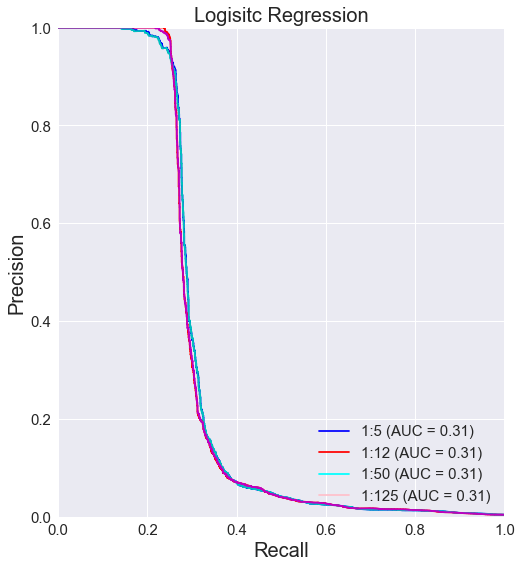

In [30]:
precision_1, recall_1, _ = precision_recall_curve(y_test, y_test_prob_1[:,1])
precision_2, recall_2, _ = precision_recall_curve(y_test, y_test_prob_2[:,1]) 
precision_3, recall_3, _ = precision_recall_curve(y_test, y_test_prob_3[:,1]) 
precision_4, recall_4, _ = precision_recall_curve(y_test, y_test_prob_4[:,1]) 
pr_auc_logreg_1 = metrics.auc(recall_1, precision_1)
pr_auc_logreg_2 = metrics.auc(recall_2, precision_2)
pr_auc_logreg_3 = metrics.auc(recall_3, precision_3)
pr_auc_logreg_4 = metrics.auc(recall_4, precision_4)
plt.figure(figsize=(8,9))
plt.plot(recall_1, precision_1, color = 'b')
plt.plot(recall_2, precision_2, color = 'r')
plt.plot(recall_3, precision_3, color = 'c')
plt.plot(recall_4, precision_4, color = 'm')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.title('Logisitc Regression', fontsize=20)
plt.tick_params(labelsize=15)

blue_line = mlines.Line2D([], [], color='blue', label='1:5 (AUC = %0.2f)' % pr_auc_logreg_1)
red_line = mlines.Line2D([], [], color='red', label='1:12 (AUC = %0.2f)' % pr_auc_logreg_2)
cyan_line = mlines.Line2D([], [], color='cyan', label='1:50 (AUC = %0.2f)' % pr_auc_logreg_3)
pink_line = mlines.Line2D([], [], color='pink', label='1:125 (AUC = %0.2f)' % pr_auc_logreg_4)

plt.legend(handles=[blue_line, red_line, cyan_line, pink_line],loc="lower right", fontsize=15)
plt.savefig('/Users/hhung/Desktop/logreg_pr.png')
plt.show()

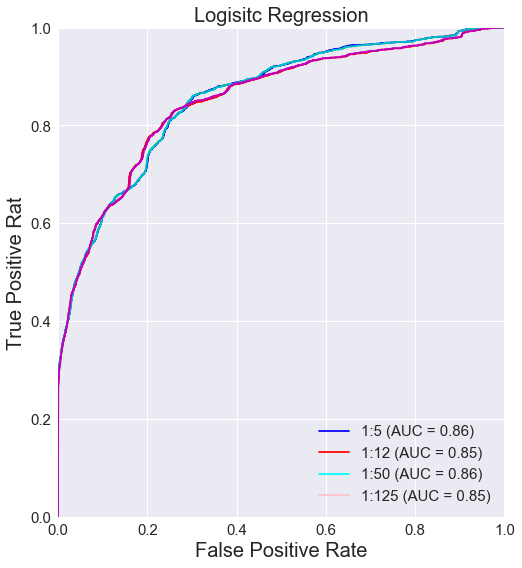

In [33]:
fpr_1, tpr_1, _ = roc_curve(y_test, y_test_prob_1[:,1])
fpr_2, tpr_2, _ = roc_curve(y_test, y_test_prob_2[:,1]) 
fpr_3, tpr_3, _ = roc_curve(y_test, y_test_prob_3[:,1]) 
fpr_4, tpr_4, _ = roc_curve(y_test, y_test_prob_4[:,1]) 
roc_auc_logreg_1 = metrics.auc(fpr_1, tpr_1)
roc_auc_logreg_2 = metrics.auc(fpr_2, tpr_2)
roc_auc_logreg_3 = metrics.auc(fpr_3, tpr_3)
roc_auc_logreg_4 = metrics.auc(fpr_4, tpr_4)
plt.figure(figsize=(8,9))
plt.plot(fpr_1, tpr_1, color = 'b')
plt.plot(fpr_2, tpr_2, color = 'r')
plt.plot(fpr_3, tpr_3, color = 'c')
plt.plot(fpr_4, tpr_4, color = 'm')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rat', fontsize=20)
plt.title('Logisitc Regression', fontsize=20)
plt.tick_params(labelsize=15)

blue_line = mlines.Line2D([], [], color='blue', label='1:5 (AUC = %0.2f)' % roc_auc_logreg_1)
red_line = mlines.Line2D([], [], color='red', label='1:12 (AUC = %0.2f)' % roc_auc_logreg_2)
cyan_line = mlines.Line2D([], [], color='cyan', label='1:50 (AUC = %0.2f)' % roc_auc_logreg_3)
pink_line = mlines.Line2D([], [], color='pink', label='1:125 (AUC = %0.2f)' % roc_auc_logreg_4)

plt.legend(handles=[blue_line, red_line, cyan_line, pink_line],loc="lower right", fontsize=15)
plt.savefig('/Users/hhung/Desktop/logreg_roc.png')
plt.show()

Using logistic regression models, we can observe models with all fraud-normal data ratios show similar performance. For little amount of undersampled normal data, the models gave higher recall, but lowest precision (if threshold is 0.5). By putting more and more normal data, the classifiers predict higher precision, but meanwhile surpress recall. Furthermore, we can see all models have similar AUC under the precision-recall curve.

## 3.3 Random Forest

Next we turn to the non-linear classifier: random forest model. The random forest models outperform logisitc regression models, by comparing the area under the precision-recall curve (AUC). Note that for each random forest, I perform grid search using 10-fold cross validation for avoiding overfitting.

#### fraud : normal = 1 : 5

In [53]:
X = train_test_split(train_neg, test_size=0.02)
training_data = pd.concat([X[1], train_pos]).sample(frac=1)
X_train = training_data[['time_diff', 'page_time_on', 'transaction_amount']]
y_train = training_data['frd']
rf_model_1 = random_forest(X_train, y_train)
evaluation(y_test, rf_model_1.predict(X_test))

('P = 0.068', 'R = 0.551')
F1 = 0.121
[[  1270   1034]
 [ 17413 549048]]


#### fraud : normal = 1 : 12

In [35]:
X = train_test_split(train_neg, test_size=0.05)
training_data = pd.concat([X[1], train_pos]).sample(frac=1)
X_train = training_data[['time_diff', 'page_time_on', 'transaction_amount']]
y_train = training_data['frd']
rf_model_2 = random_forest(X_train, y_train)
evaluation(y_test, rf_model_2.predict(X_test))

('P = 0.179', 'R = 0.431')
F1 = 0.253
[[   994   1310]
 [  4561 561900]]


#### fraud : normal = 1 : 50

In [37]:
X = train_test_split(train_neg, test_size=0.2)
training_data = pd.concat([X[1], train_pos]).sample(frac=1)
X_train = training_data[['time_diff', 'page_time_on', 'transaction_amount']]
y_train = training_data['frd']
rf_model_3 = random_forest(X_train, y_train)
evaluation(y_test, rf_model_3.predict(X_test))

('P = 0.737', 'R = 0.320')
F1 = 0.447
[[   738   1566]
 [   263 566198]]


#### fraud : normal = 1 : 125

In [38]:
X = train_test_split(train_neg, test_size=0.5)
training_data = pd.concat([X[1], train_pos]).sample(frac=1)
X_train = training_data[['time_diff', 'page_time_on', 'transaction_amount']]
y_train = training_data['frd']
rf_model_4 = random_forest(X_train, y_train)
evaluation(y_test, rf_model_4.predict(X_test))

('P = 0.935', 'R = 0.306')
F1 = 0.461
[[   705   1599]
 [    49 566412]]


#### fraud : normal = 1 : 200

In [39]:
X = train_test_split(train_neg, test_size=0.8)
training_data = pd.concat([X[1], train_pos]).sample(frac=1)
X_train = training_data[['time_diff', 'page_time_on', 'transaction_amount']]
y_train = training_data['frd']
rf_model_5 = random_forest(X_train, y_train)
evaluation(y_test, rf_model_5.predict(X_test))

('P = 0.979', 'R = 0.298')
F1 = 0.457
[[   686   1618]
 [    15 566446]]


#### precision-recall curve

In [54]:
y_test_prob_1 = rf_model_1.predict_proba(X_test)
y_test_prob_2 = rf_model_2.predict_proba(X_test)
y_test_prob_3 = rf_model_3.predict_proba(X_test)
y_test_prob_4 = rf_model_4.predict_proba(X_test)
y_test_prob_5 = rf_model_5.predict_proba(X_test)

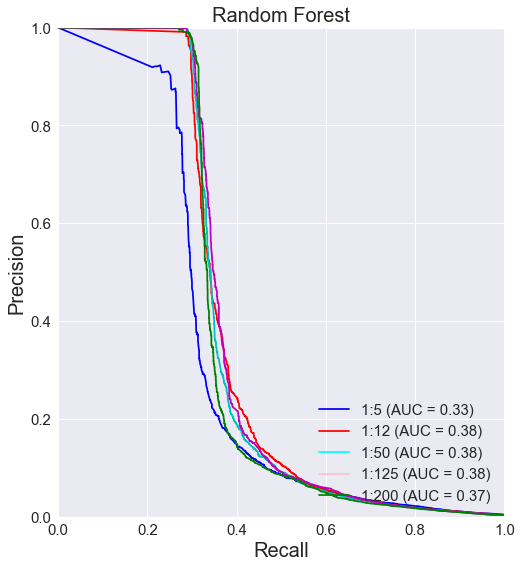

In [55]:
precision_1, recall_1, _ = precision_recall_curve(y_test, y_test_prob_1[:,1])
precision_2, recall_2, _ = precision_recall_curve(y_test, y_test_prob_2[:,1]) 
precision_3, recall_3, _ = precision_recall_curve(y_test, y_test_prob_3[:,1])
precision_4, recall_4, _ = precision_recall_curve(y_test, y_test_prob_4[:,1]) 
precision_5, recall_5, _ = precision_recall_curve(y_test, y_test_prob_5[:,1])
pr_auc_rf_1 = metrics.auc(recall_1, precision_1)
pr_auc_rf_2 = metrics.auc(recall_2, precision_2)
pr_auc_rf_3 = metrics.auc(recall_3, precision_3)
pr_auc_rf_4 = metrics.auc(recall_4, precision_4)
pr_auc_rf_5 = metrics.auc(recall_5, precision_5)

plt.figure(figsize=(8,9))
plt.plot(recall_1, precision_1, color = 'b')
plt.plot(recall_2, precision_2, color = 'r')
plt.plot(recall_3, precision_3, color = 'c')
plt.plot(recall_4, precision_4, color = 'm')
plt.plot(recall_5, precision_5, color = 'g')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.title('Random Forest', fontsize=20)
plt.tick_params(labelsize=15)
blue_line = mlines.Line2D([], [], color='blue', label='1:5 (AUC = %0.2f)' % pr_auc_rf_1)
red_line = mlines.Line2D([], [], color='red', label='1:12 (AUC = %0.2f)' % pr_auc_rf_2)
cyan_line = mlines.Line2D([], [], color='cyan', label='1:50 (AUC = %0.2f)' % pr_auc_rf_3)
pink_line = mlines.Line2D([], [], color='pink', label='1:125 (AUC = %0.2f)' % pr_auc_rf_4)
green_line = mlines.Line2D([], [], color='green', label='1:200 (AUC = %0.2f)' % pr_auc_rf_5)

plt.legend(handles=[blue_line, red_line, cyan_line, pink_line, green_line],loc="lower right", fontsize=15)
plt.savefig('/Users/hhung/Desktop/randomforest_pr.png')
plt.show()

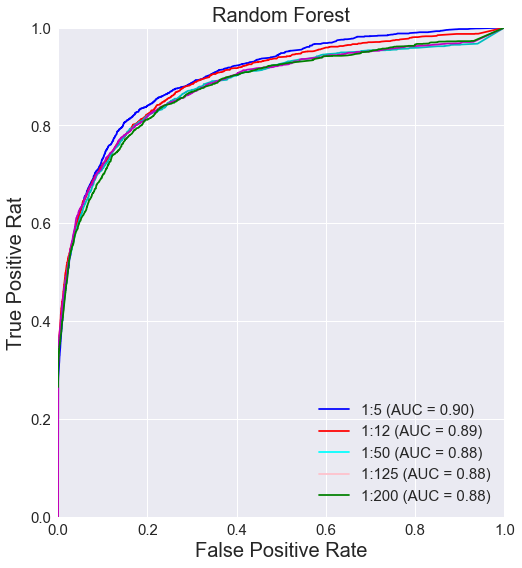

In [56]:
fpr_1, tpr_1, _ = roc_curve(y_test, y_test_prob_1[:,1])
fpr_2, tpr_2, _ = roc_curve(y_test, y_test_prob_2[:,1]) 
fpr_3, tpr_3, _ = roc_curve(y_test, y_test_prob_3[:,1]) 
fpr_4, tpr_4, _ = roc_curve(y_test, y_test_prob_4[:,1]) 
fpr_5, tpr_5, _ = roc_curve(y_test, y_test_prob_5[:,1]) 
roc_auc_rf_1 = metrics.auc(fpr_1, tpr_1)
roc_auc_rf_2 = metrics.auc(fpr_2, tpr_2)
roc_auc_rf_3 = metrics.auc(fpr_3, tpr_3)
roc_auc_rf_4 = metrics.auc(fpr_4, tpr_4)
roc_auc_rf_5 = metrics.auc(fpr_5, tpr_5)
plt.figure(figsize=(8,9))
plt.plot(fpr_1, tpr_1, color = 'b')
plt.plot(fpr_2, tpr_2, color = 'r')
plt.plot(fpr_3, tpr_3, color = 'c')
plt.plot(fpr_4, tpr_4, color = 'm')
plt.plot(fpr_5, tpr_5, color = 'g')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rat', fontsize=20)
plt.title('Random Forest', fontsize=20)
plt.tick_params(labelsize=15)

blue_line = mlines.Line2D([], [], color='blue', label='1:5 (AUC = %0.2f)' % roc_auc_rf_1)
red_line = mlines.Line2D([], [], color='red', label='1:12 (AUC = %0.2f)' % roc_auc_rf_2)
cyan_line = mlines.Line2D([], [], color='cyan', label='1:50 (AUC = %0.2f)' % roc_auc_rf_3)
pink_line = mlines.Line2D([], [], color='pink', label='1:125 (AUC = %0.2f)' % roc_auc_rf_4)
green_line = mlines.Line2D([], [], color='green', label='1:200 (AUC = %0.2f)' % roc_auc_rf_5)

plt.legend(handles=[blue_line, red_line, cyan_line, pink_line, green_line],loc="lower right", fontsize=15)
plt.savefig('/Users/hhung/Desktop/randomforest_roc.png')
plt.show()

#### feature importance

Here shows feature importance for 1:5 and 1:200 random forest models. We found 'transaction_amount' is always the most important. For small fraud-normal ratio data, 'time_diff' plays second important role. However, for large fraud-normal ratio, the importance between 'time_diff' and 'page_time_on' are similar. 

In [314]:
importance = rf_model_1.feature_importances_
attribute = X_train.columns

v = sorted(range(len(importance)), key=lambda k: importance[k], reverse=True)
sorted_importance = [importance[i] for i in v]
sorted_attribute = [attribute[i] for i in v]

df_importance = pd.DataFrame({'variable': sorted_attribute, 'importance' : sorted_importance})
df_importance.sort_index().head(16)

,importance,variable
0,0.732562,transaction_amount
1,0.214425,time_diff
2,0.053013,page_time_on


In [318]:
importance = rf_model_5.feature_importances_
attribute = X_train.columns

v = sorted(range(len(importance)), key=lambda k: importance[k], reverse=True)
sorted_importance = [importance[i] for i in v]
sorted_attribute = [attribute[i] for i in v]

df_importance = pd.DataFrame({'variable': sorted_attribute, 'importance' : sorted_importance})
df_importance.sort_index().head(16)

,importance,variable
0,0.899342,transaction_amount
1,0.064805,page_time_on
2,0.035853,time_diff


## 3.4 Ensemble Learning

Finally let's try ensemble learning. Here I used five classifier $-$ logisitc regression, decision tree, random forest, Naive Bayes and Adaboosting. AUC under the precision-recall curve is slightly worse than only using random forest as classifier. 

In [43]:
from sklearn.ensemble import VotingClassifier

In [44]:
X = train_test_split(train_neg, test_size=0.02)
training_data = pd.concat([X[1], train_pos]).sample(frac=1)
X_train = training_data[['time_diff', 'page_time_on', 'transaction_amount']]
y_train = training_data['frd']

model_1 = VotingClassifier(estimators=[('lr', LogisticRegression(random_state=1)), 
                                     ('dt', DecisionTreeClassifier(random_state=1)), 
                                     ('rf', RandomForestClassifier(random_state=1)),
                                    ('nb', GaussianNB()), 
                                    ('ada', AdaBoostClassifier())], 
                         voting='soft', weights=[1, 2, 2, 1, 2])
model_1.fit(X_train, y_train)
evaluation(y_test, model_1.predict(X_test))

('P = 0.052', 'R = 0.610')
F1 = 0.097
[[  1406    898]
 [ 25425 541036]]


In [45]:
X = train_test_split(train_neg, test_size=0.05)
training_data = pd.concat([X[1], train_pos]).sample(frac=1)
X_train = training_data[['time_diff', 'page_time_on', 'transaction_amount']]
y_train = training_data['frd']

model_2 = VotingClassifier(estimators=[('lr', LogisticRegression(random_state=1)), 
                                     ('dt', DecisionTreeClassifier(random_state=1)), 
                                     ('rf', RandomForestClassifier(random_state=1)),
                                    ('nb', GaussianNB()), 
                                    ('ada', AdaBoostClassifier())], 
                         voting='soft', weights=[1, 2, 2, 1, 2])
model_2.fit(X_train, y_train)
evaluation(y_test, model_2.predict(X_test))

('P = 0.100', 'R = 0.496')
F1 = 0.167
[[  1143   1161]
 [ 10260 556201]]


In [46]:
X = train_test_split(train_neg, test_size=0.2)
training_data = pd.concat([X[1], train_pos]).sample(frac=1)
X_train = training_data[['time_diff', 'page_time_on', 'transaction_amount']]
y_train = training_data['frd']

model_3 = VotingClassifier(estimators=[('lr', LogisticRegression(random_state=1)), 
                                     ('dt', DecisionTreeClassifier(random_state=1)), 
                                     ('rf', RandomForestClassifier(random_state=1)),
                                    ('nb', GaussianNB()), 
                                    ('ada', AdaBoostClassifier())], 
                         voting='soft', weights=[1, 2, 2, 1, 2])
model_3.fit(X_train, y_train)
evaluation(y_test, model_3.predict(X_test))

('P = 0.283', 'R = 0.389')
F1 = 0.327
[[   896   1408]
 [  2273 564188]]


In [47]:
X = train_test_split(train_neg, test_size=0.5)
training_data = pd.concat([X[1], train_pos]).sample(frac=1)
X_train = training_data[['time_diff', 'page_time_on', 'transaction_amount']]
y_train = training_data['frd']

model_4 = VotingClassifier(estimators=[('lr', LogisticRegression(random_state=1)), 
                                     ('dt', DecisionTreeClassifier(random_state=1)), 
                                     ('rf', RandomForestClassifier(random_state=1)),
                                    ('nb', GaussianNB()), 
                                    ('ada', AdaBoostClassifier())], 
                         voting='soft', weights=[1, 2, 2, 1, 2])
model_4.fit(X_train, y_train)
evaluation(y_test, model_4.predict(X_test))

('P = 0.515', 'R = 0.338')
F1 = 0.408
[[   778   1526]
 [   734 565727]]


In [57]:
y_test_prob_1 = model_1.predict_proba(X_test)
y_test_prob_2 = model_2.predict_proba(X_test)
y_test_prob_3 = model_3.predict_proba(X_test)
y_test_prob_4 = model_4.predict_proba(X_test)

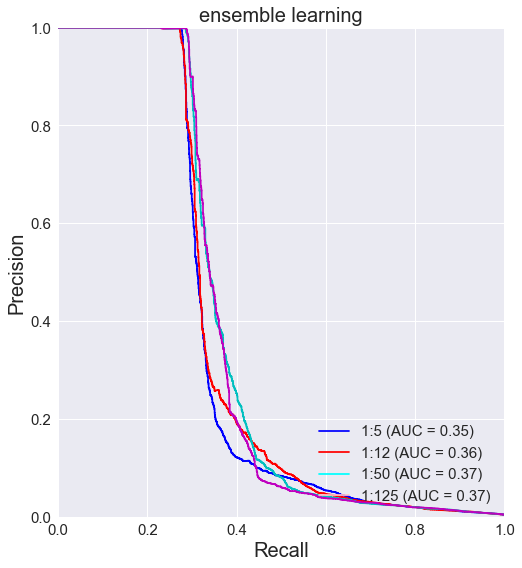

In [49]:
precision_1, recall_1, _ = precision_recall_curve(y_test, y_test_prob_1[:,1])
precision_2, recall_2, _ = precision_recall_curve(y_test, y_test_prob_2[:,1]) 
precision_3, recall_3, _ = precision_recall_curve(y_test, y_test_prob_3[:,1])
precision_4, recall_4, _ = precision_recall_curve(y_test, y_test_prob_4[:,1]) 

pr_auc_ensemble_1 = metrics.auc(recall_1, precision_1)
pr_auc_ensemble_2 = metrics.auc(recall_2, precision_2)
pr_auc_ensemble_3 = metrics.auc(recall_3, precision_3)
pr_auc_ensemble_4 = metrics.auc(recall_4, precision_4)


plt.figure(figsize=(8,9))
plt.plot(recall_1, precision_1, color = 'b')
plt.plot(recall_2, precision_2, color = 'r')
plt.plot(recall_3, precision_3, color = 'c')
plt.plot(recall_4, precision_4, color = 'm')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.tick_params(labelsize=15)
blue_line = mlines.Line2D([], [], color='blue', label='1:5 (AUC = %0.2f)' % pr_auc_ensemble_1)
red_line = mlines.Line2D([], [], color='red', label='1:12 (AUC = %0.2f)' % pr_auc_ensemble_2)
cyan_line = mlines.Line2D([], [], color='cyan', label='1:50 (AUC = %0.2f)' % pr_auc_ensemble_3)
pink_line = mlines.Line2D([], [], color='pink', label='1:125 (AUC = %0.2f)' % pr_auc_ensemble_4)

plt.legend(handles=[blue_line, red_line, cyan_line, pink_line],loc="lower right", fontsize=15)
plt.title('ensemble learning', fontsize=20)
plt.savefig('/Users/hhung/Desktop/ensemble_pr.png')
plt.show()

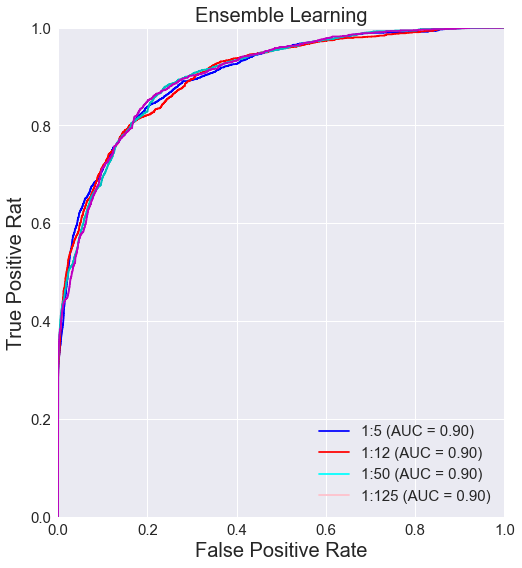

In [58]:
fpr_1, tpr_1, _ = roc_curve(y_test, y_test_prob_1[:,1])
fpr_2, tpr_2, _ = roc_curve(y_test, y_test_prob_2[:,1]) 
fpr_3, tpr_3, _ = roc_curve(y_test, y_test_prob_3[:,1]) 
fpr_4, tpr_4, _ = roc_curve(y_test, y_test_prob_4[:,1])  
roc_auc_ensemble_1 = metrics.auc(fpr_1, tpr_1)
roc_auc_ensemble_2 = metrics.auc(fpr_2, tpr_2)
roc_auc_ensemble_3 = metrics.auc(fpr_3, tpr_3)
roc_auc_ensemble_4 = metrics.auc(fpr_4, tpr_4)
plt.figure(figsize=(8,9))
plt.plot(fpr_1, tpr_1, color = 'b')
plt.plot(fpr_2, tpr_2, color = 'r')
plt.plot(fpr_3, tpr_3, color = 'c')
plt.plot(fpr_4, tpr_4, color = 'm')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rat', fontsize=20)
plt.title('Ensemble Learning', fontsize=20)
plt.tick_params(labelsize=15)

blue_line = mlines.Line2D([], [], color='blue', label='1:5 (AUC = %0.2f)' % roc_auc_ensemble_1)
red_line = mlines.Line2D([], [], color='red', label='1:12 (AUC = %0.2f)' % roc_auc_ensemble_2)
cyan_line = mlines.Line2D([], [], color='cyan', label='1:50 (AUC = %0.2f)' % roc_auc_ensemble_3)
pink_line = mlines.Line2D([], [], color='pink', label='1:125 (AUC = %0.2f)' % roc_auc_ensemble_4)

plt.legend(handles=[blue_line, red_line, cyan_line, pink_line],loc="lower right", fontsize=15)
plt.savefig('/Users/hhung/Desktop/ensemble_roc.png')
plt.show()